# Melhores métodos de clusterização

## Comparar os três cenários entre embeddings completos, PCA (n_componentes = x) ou UMAP (n_componentes=y)

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set_theme(style="whitegrid")

base_clusters_path = 'clusters/'


In [2]:
def collect_files_from_path(path_to_search, dataset, reduction_method, n_components, all_results_dfs, allowed_methods):
    """
    Função auxiliar para coletar arquivos CSV de resultados de clusterização de um dado caminho.
    Coleta diretamente do path_to_search, assumindo que os CSVs estão lá.
    """
    found_result_files = []

    # Procura os arquivos CSV diretamente no path_to_search
    # Não vamos mais inspecionar subpastas 'run_*' para os CSVs aqui,
    # pois a estrutura do usuário indica que os CSVs estão no mesmo nível que essas pastas.
    if not os.path.exists(path_to_search):
        # print(f"Aviso: Caminho não encontrado {path_to_search}. Pulando.") # Opcional: descomentar para debug
        return

    # files_in_current_path = [f for f in os.listdir(path_to_search) if f.endswith('_results.csv')]
    files_in_current_path = [f for f in os.listdir(path_to_search)
                         if f.endswith('_results.csv') and
                         any(f'run_{method}' in f for method in allowed_methods)]

    for f in files_in_current_path:
        found_result_files.append(os.path.join(path_to_search, f))

    if not found_result_files:
        # print(f"Aviso: Nenhum arquivo '_results.csv' encontrado em {path_to_search}.") # Opcional: descomentar para debug
        return # Não há arquivos para processar nesta pasta

    for file_path in found_result_files:
        try:
            df = pd.read_csv(file_path)
            if df.empty: # Checagem adicional se o CSV estiver vazio
                print(f"Aviso: Arquivo CSV vazio encontrado e pulado: {file_path}")
                continue

            df['Dataset'] = dataset
            df['Reduction_Method'] = reduction_method
            df['N_Components'] = n_components

            if 'Metric_Distance' in df.columns:
                df = df.drop(columns=['Metric_Distance'])

            df['Actual_Clusters'] = np.nan
            df['Input_K_Param'] = np.nan

            if 'N_Clusters_Actual' in df.columns:
                df['Actual_Clusters'] = df['N_Clusters_Actual']
                if 'k' in df.columns:
                    df['Input_K_Param'] = df['k']
                elif 'min_cluster_size' in df.columns:
                    df['Input_K_Param'] = df['min_cluster_size']
            elif 'k' in df.columns:
                df['Actual_Clusters'] = df['k']
                df['Input_K_Param'] = df['k']
            elif 'min_cluster_size' in df.columns:
                df['Input_K_Param'] = df['min_cluster_size']

            if 'Method' not in df.columns:
                # Tenta inferir o nome do método a partir do nome do arquivo
                # Ex: ML-1M_run_kmeans_results.csv -> kmeans
                # Ou: PetSupplies_run_kmeans_results.csv -> kmeans
                base_name = os.path.basename(file_path)
                # Remove o sufixo '_results.csv'
                name_without_suffix = base_name.replace('_results.csv', '')
                # Pega a última parte após o último '_' que deve ser o nome do método,
                # lidando com prefixos como 'run_'
                parts = name_without_suffix.split('_')
                method_name_from_file = parts[-1] if not parts[-1].isdigit() else parts[-2] # Pega o último ou penúltimo se o último for dígito (raro)
                if parts[-2] == 'run': # Se o padrão for Dataset_run_method
                     method_name_from_file = parts[-1]

                df['Method'] = method_name_from_file.capitalize()
            else:
                df['Method'] = df['Method'].str.replace('run_', '').str.capitalize()


            all_results_dfs.append(df)
        except pd.errors.EmptyDataError:
            print(f"Erro ao ler arquivo {file_path}: Sem colunas para analisar. (Arquivo pode estar vazio ou mal formatado)")
        except Exception as e:
            print(f"Erro ao ler arquivo {file_path}: {e}")

# A função collect_all_clustering_results_selected_scenarios permanece a mesma,
# pois ela chama a collect_files_from_path corrigida.
def collect_all_clustering_results_selected_scenarios(base_clusters_path):
    all_results_dfs = []

    # Apenas os datasets desejados
    datasets_in_clusters = ['Beauty', 'ML-1M']

    selected_scenarios = {
        'embeddings_completos': {'Reduction_Method': 'None', 'N_Components': 'Full', 'Description': 'Embeddings Originais'},
        'pca': {'Reduction_Method': 'PCA', 'Description': 'Redução com PCA'},
        'umap': {'Reduction_Method': 'UMAP', 'Description': 'Redução com UMAP'}
    }

    print("Iniciando coleta de resultados de clusterização para cenários selecionados...")

    allowed_methods = ['kmeans', 'agnes', 'fasterpam']

    for dataset in datasets_in_clusters:
        dataset_path = os.path.join(base_clusters_path, dataset)
        print(f"\nColetando resultados para o Dataset: {dataset}")

        for scenario_folder, scenario_info in selected_scenarios.items():
            current_scenario_full_path = os.path.join(dataset_path, scenario_folder)

            if not os.path.exists(current_scenario_full_path):
                print(f"Cenário de pasta '{scenario_folder}' não encontrado para o dataset '{dataset}': {current_scenario_full_path}. Pulando.")
                continue

            if scenario_folder in ['pca', 'umap']:
                n_components_subfolders = [f for f in os.listdir(current_scenario_full_path)
                                           if os.path.isdir(os.path.join(current_scenario_full_path, f))
                                           and f.startswith('n_components')]

                if not n_components_subfolders:
                    print(f"Aviso: Nenhuma subpasta 'n_components' encontrada em {current_scenario_full_path}. Pulando este cenário para {dataset}.")
                    continue

                for n_comp_folder in n_components_subfolders:
                    n_components_val = n_comp_folder.replace('n_components', '')
                    path_to_search_files = os.path.join(current_scenario_full_path, n_comp_folder)

                    files_in_current_path = [f for f in os.listdir(path_to_search_files) if f.endswith('_results.csv')]
                    # for f in files_in_current_path:
                    #     if any(m in f for m in ['run_kmeans', 'run_agnes', 'run_fasterpam']):
                    #         collect_files_from_path(path_to_search_files, dataset, scenario_info['Reduction_Method'], n_components_val, all_results_dfs, allowed_methods)
                    collect_files_from_path(path_to_search_files, dataset, scenario_info['Reduction_Method'], n_components_val, all_results_dfs, allowed_methods)

            else:
                
                files_in_current_path = [f for f in os.listdir(current_scenario_full_path) if f.endswith('_results.csv')]
                # for f in files_in_current_path:
                #     if any(m in f for m in ['run_kmeans', 'run_agnes', 'run_fasterpam']):
                #         collect_files_from_path(current_scenario_full_path, dataset, scenario_info['Reduction_Method'], scenario_info['N_Components'], all_results_dfs)
                collect_files_from_path(current_scenario_full_path, dataset, scenario_info['Reduction_Method'], scenario_info['N_Components'], all_results_dfs, allowed_methods)



    if all_results_dfs:
        master_df = pd.concat(all_results_dfs, ignore_index=True)
        return master_df
    else:
        print("Nenhum arquivo de resultado encontrado nos cenários selecionados.")
        return pd.DataFrame()


In [3]:
# Executa a coleta de todos os resultados
master_results_df = collect_all_clustering_results_selected_scenarios(base_clusters_path=base_clusters_path)

if not master_results_df.empty:
    print(f"\nTotal de resultados coletados: {len(master_results_df)}")
    print(master_results_df['Method'].values)
else:
    print("O DataFrame mestre de resultados está vazio após a coleta. Verifique os caminhos e a estrutura.")

Iniciando coleta de resultados de clusterização para cenários selecionados...

Coletando resultados para o Dataset: Beauty

Coletando resultados para o Dataset: ML-1M

Total de resultados coletados: 1369
['Agnes' 'Agnes' 'Agnes' ... 'Kmeans' 'Kmeans' 'Kmeans']



--- Desempenho Médio dos Cenários de Redução (Global) ---
Esta tabela ajuda a identificar os melhores cenários de representação de embeddings.
Os cenários são ranqueados pela média do Silhouette e Dunn de TODAS as clusterizações nele.
   Reduction_Method N_Components  Avg_Silhouette  Avg_Dunn
12             UMAP           32        0.341389  0.547880
9              UMAP          128        0.341299  0.522831
16             UMAP            8        0.340711  0.514709
11             UMAP          256        0.340276  0.514228
15             UMAP           64        0.339750  0.535247
14             UMAP          512        0.338634  0.484907
10             UMAP           16        0.330397  0.545064
13             UMAP            4        0.323347  0.454802
5               PCA            4        0.109080  0.231254
7               PCA           64        0.092476  0.215662
1               PCA          128        0.092083  0.209956
3               PCA          256        0.091901  0.2117

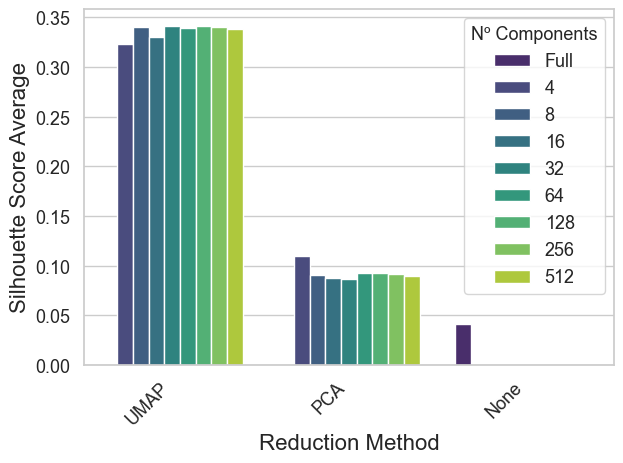

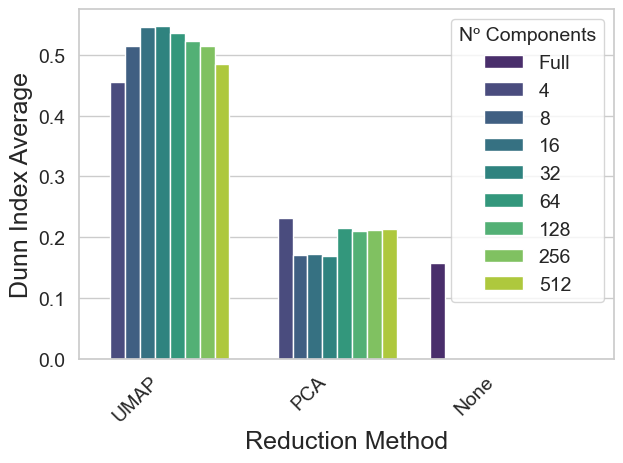

In [4]:
if not master_results_df.empty:
    master_results_df['Silhouette'] = pd.to_numeric(master_results_df['Silhouette'], errors='coerce').astype(float)
    master_results_df['Dunn'] = pd.to_numeric(master_results_df['Dunn'], errors='coerce').astype(float)
    master_results_df['Actual_Clusters'] = pd.to_numeric(master_results_df['Actual_Clusters'], errors='coerce').astype(float)
    master_results_df['Input_K_Param'] = pd.to_numeric(master_results_df['Input_K_Param'], errors='coerce').astype(float)

    master_results_df.dropna(subset=['Silhouette', 'Dunn', 'Actual_Clusters'], inplace=True)
    
    min_clusters_threshold_for_analysis = 2 
    filtered_for_avg_analysis = master_results_df[master_results_df['Actual_Clusters'] >= min_clusters_threshold_for_analysis].copy()

    if filtered_for_avg_analysis.empty:
        print(f"\nNenhum resultado restante para análise após filtragem de clusters < {min_clusters_threshold_for_analysis}.")
    else:
        average_performance_by_scenario = filtered_for_avg_analysis.groupby([
            'Reduction_Method', 
            'N_Components'
        ]).agg(
            Avg_Silhouette=('Silhouette', 'mean'),
            Avg_Dunn=('Dunn', 'mean'),
        ).reset_index()

        overall_best_scenarios = average_performance_by_scenario.sort_values(
            by=['Avg_Silhouette', 'Avg_Dunn'], 
            ascending=[False, False]
        )

        print("\n--- Desempenho Médio dos Cenários de Redução (Global) ---")
        print("Esta tabela ajuda a identificar os melhores cenários de representação de embeddings.")
        print("Os cenários são ranqueados pela média do Silhouette e Dunn de TODAS as clusterizações nele.")
        print(overall_best_scenarios.head(20).to_string())

        print("\n--- Visualizando os Melhores Cenários de Redução ---")

        overall_best_scenarios['N_Components_Plot'] = overall_best_scenarios['N_Components'].astype(str)
        overall_best_scenarios['N_Components_Plot'] = pd.Categorical(overall_best_scenarios['N_Components_Plot'], 
                                                                    categories=sorted(overall_best_scenarios['N_Components_Plot'].unique(), 
                                                                                      key=lambda x: (x != 'Full', float(x) if x.replace('.','',1).isdigit() else x)), ordered=True)
        
        label_fontsize = 18
        tick_fontsize = 14
        legend_fontsize = 14

        ax = sns.barplot(
        x='Reduction_Method', 
        y='Avg_Silhouette', 
        hue='N_Components_Plot', 
        data=overall_best_scenarios, 
        palette='viridis'
        )
        plt.xlabel('Reduction Method', fontsize=16)
        plt.ylabel('Silhouette Score Average', fontsize=16)
        plt.xticks(rotation=45, ha='right', fontsize=13)
        plt.yticks(fontsize=13)
        plt.legend(
            title='Nº Components', 
            loc='upper right', 
            fontsize=13, 
            title_fontsize=13,
            frameon=True
        )
        ax.set_xlim(-0.5, 2.5)
        plt.tight_layout()
        plt.savefig("silhouette_plot_cortado.png", dpi=300)
        plt.show()

        # DUNN INDEX
        ax = sns.barplot(
            x='Reduction_Method', 
            y='Avg_Dunn', 
            hue='N_Components_Plot', 
            data=overall_best_scenarios, 
            palette='viridis'
        )

        plt.xlabel('Reduction Method', fontsize=label_fontsize)
        plt.ylabel('Dunn Index Average', fontsize=label_fontsize)
        plt.xticks(rotation=45, ha='right', fontsize=tick_fontsize)
        plt.yticks(fontsize=tick_fontsize)
        plt.legend(
            title='Nº Components', 
            loc='upper right', 
            fontsize=legend_fontsize, 
            title_fontsize=legend_fontsize,
            frameon=True
        )
        ax.set_xlim(-0.5, 2.7)

        plt.tight_layout()
        plt.savefig("dunn_plot_cortado.png", dpi=300)
        plt.show()


else:
    print("DataFrame mestre de resultados está vazio. Execute a célula anterior.")

In [5]:
# --- Seleção do(s) Melhor(es) Cenário(s) para a Próxima Etapa ---
        
selected_reduction_method = overall_best_scenarios.iloc[0]['Reduction_Method']
selected_n_components = overall_best_scenarios.iloc[0]['N_Components']

print(f"\n--- Cenário Selecionado para Otimização Fina dos Métodos de Clusterização (Globalmente) ---")
print(f"Método de Redução: {selected_reduction_method}")
print(f"Nº de Componentes: {selected_n_components}")

global_selected_scenario_df = master_results_df[
    (master_results_df['Reduction_Method'] == selected_reduction_method) &
    (master_results_df['N_Components'] == selected_n_components)
].copy()


--- Cenário Selecionado para Otimização Fina dos Métodos de Clusterização (Globalmente) ---
Método de Redução: UMAP
Nº de Componentes: 32


In [6]:
# Filtra o DataFrame mestre para o melhor cenário
umap_32_results = master_results_df[
    (master_results_df['Reduction_Method'] == 'UMAP') &
    (master_results_df['N_Components'] == '32')
].copy()

if umap_32_results.empty:
    print("Nenhum resultado para o cenário UMAP 32. Verifique sua coleta de dados.")
else:
    print(f"\n--- Resultados para o Cenário UMAP 32 ({len(umap_32_results)} entradas) ---")
    print(umap_32_results.head())


--- Resultados para o Cenário UMAP 32 (102 entradas) ---
    Method   k  Silhouette      Dunn Dataset Reduction_Method N_Components  \
357  Agnes   2    0.345315  0.359217  Beauty             UMAP           32   
358  Agnes   5    0.394078  0.291312  Beauty             UMAP           32   
359  Agnes  10    0.364386  0.179692  Beauty             UMAP           32   
360  Agnes  30    0.291632  0.162549  Beauty             UMAP           32   
361  Agnes  50    0.278865  0.630374  Beauty             UMAP           32   

     Actual_Clusters  Input_K_Param  
357              2.0            2.0  
358              5.0            5.0  
359             10.0           10.0  
360             30.0           30.0  
361             50.0           50.0  


In [8]:
umap_32_results[umap_32_results['k']==2]

,Method,k,Silhouette,Dunn,Dataset,Reduction_Method,N_Components,Actual_Clusters,Input_K_Param
357,Agnes,2,0.345315,0.359217,Beauty,UMAP,32,2.0,2.0
374,Fasterpam,2,0.368114,0.362423,Beauty,UMAP,32,2.0,2.0
391,Kmeans,2,0.368702,0.363592,Beauty,UMAP,32,2.0,2.0
1110,Agnes,2,0.549187,1.142262,ML-1M,UMAP,32,2.0,2.0
1127,Fasterpam,2,0.552151,1.133771,ML-1M,UMAP,32,2.0,2.0
1144,Kmeans,2,0.552151,1.136737,ML-1M,UMAP,32,2.0,2.0


Gráfico de Agnes em ML-1M


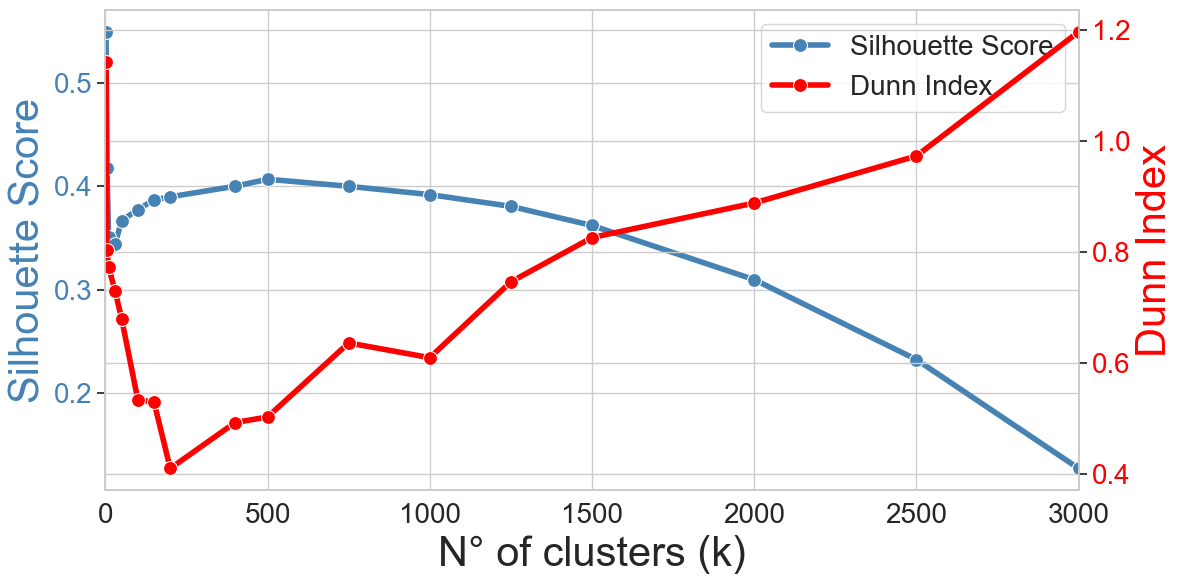

Gráfico de Fasterpam em ML-1M


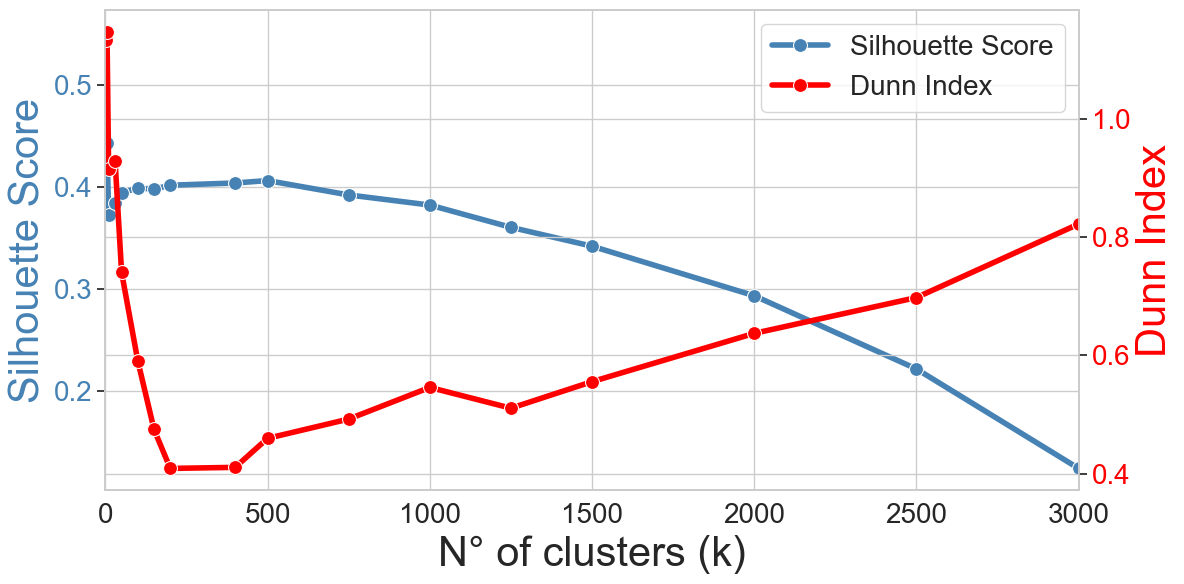

Gráfico de Kmeans em ML-1M


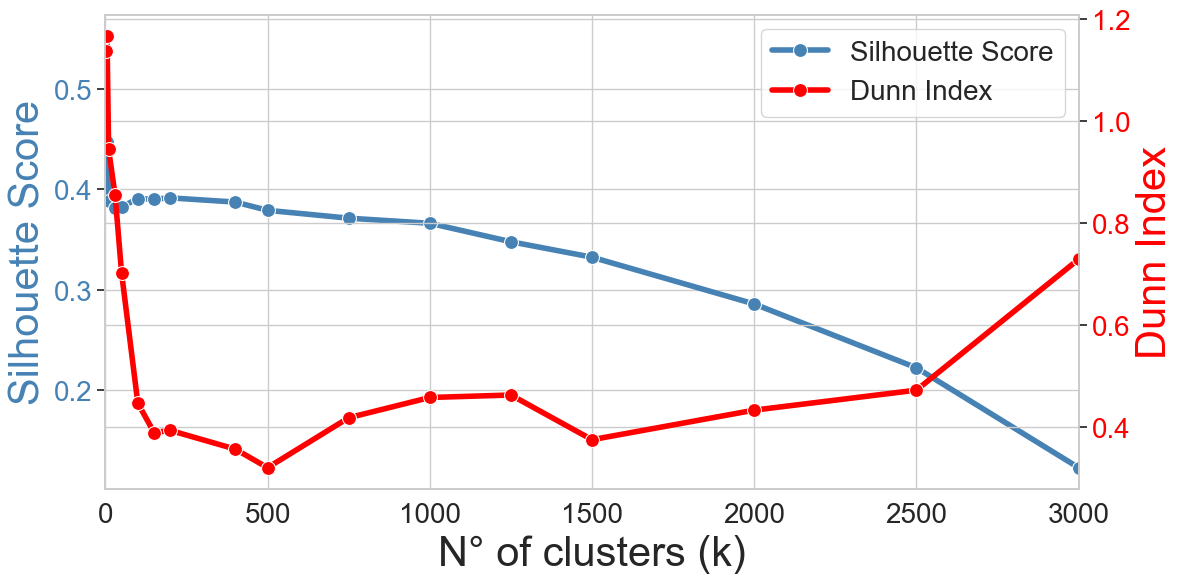

In [15]:
# Configurações ajustáveis
chosen_dataset = 'ML-1M'
min_k = 2
fig_size = (12, 6)
font_size_labels = 30
font_size_ticks = 20
font_size_legend = 20
line_width = 4
marker_size = 10
plot_metric = 'ambos'  # opções: 'Silhouette', 'Dunn', 'ambos'
x_range = (0, 3000)

x_axis_label_plot = 'N° of clusters (k)'

if 'global_selected_scenario_df' in locals() and not global_selected_scenario_df.empty:
    current_df = global_selected_scenario_df[
        global_selected_scenario_df['Dataset'] == chosen_dataset
    ]

    for method in current_df['Method'].unique():
        print(f"Gráfico de {method} em {chosen_dataset}")

        df = current_df[current_df['Method'] == method].copy()
        x_col = (
            'Input_K_Param'
            if 'Input_K_Param' in df.columns and not df['Input_K_Param'].isnull().all()
            and not df['Input_K_Param'].equals(df['Actual_Clusters'])
            else 'Actual_Clusters'
        )

        df = df.sort_values(by=x_col)
        df = df[df[x_col] >= min_k]

        plt.figure(figsize=fig_size)
        ax1 = plt.gca()

        legend_items = []

        # Silhouette plot
        if plot_metric in ['Silhouette', 'ambos']:
            line1 = sns.lineplot(
                x=x_col, y='Silhouette', data=df,
                marker='o', markersize=marker_size,
                linewidth=line_width, color='steelblue',
                label='Silhouette Score', ax=ax1
            )
            ax1.set_ylabel('Silhouette Score', fontsize=font_size_labels, color='steelblue')
            ax1.tick_params(axis='y', labelsize=font_size_ticks, labelcolor='steelblue')
            ax1.tick_params(axis='x', labelsize=font_size_ticks)
            
            legend_items.append(('Silhouette Score', line1.lines[0]))

        # Dunn Index plot
        if plot_metric in ['Dunn', 'ambos']:
            dunn_on_secondary = (
                plot_metric == 'ambos' and (
                    df['Dunn'].max() > 1.5 * df['Silhouette'].max()
                    or df['Dunn'].min() < 0.5 * df['Silhouette'].min()
                )
            )
            if dunn_on_secondary:
                ax2 = ax1.twinx()
                line2 = sns.lineplot(
                    x=x_col, y='Dunn', data=df,
                    marker='o', markersize=marker_size,
                    linewidth=line_width, color='red',
                    ax=ax2
                )
                ax2.set_ylabel('Dunn Index', fontsize=font_size_labels, color='red')
                ax2.tick_params(axis='y', labelsize=font_size_ticks, labelcolor='red')
                legend_items.append(('Dunn Index', line2.lines[0]))
            else:
                line2 = sns.lineplot(
                    x=x_col, y='Dunn', data=df,
                    marker='o', markersize=marker_size,
                    linewidth=line_width, color='red',
                    label='Dunn Index', ax=ax1
                )
                legend_items.append(('Dunn Index', line2.lines[-1]))

        # Eixo X
        ax1.set_xlabel(x_axis_label_plot, fontsize=font_size_labels)
        plt.xlim(x_range)
        plt.xticks(fontsize=font_size_ticks)
        plt.yticks(fontsize=font_size_ticks)

        # Legenda única com moldura
        handles, labels = zip(*legend_items)
        ax1.legend(
            labels, handles,
            fontsize=font_size_legend,
            loc='upper right',
            frameon=True
        )

        plt.tight_layout()
        plt.show()


In [8]:
if 'global_selected_scenario_df' in locals() and not global_selected_scenario_df.empty:
    print("\n--- Melhores Ajustes de Parâmetros por Método e Dataset ---")
    print(f"Analisando no cenário: Redução={selected_reduction_method}, N_Components={selected_n_components}")

    # --- PARÂMETROS DE FILTRO E EXIBIÇÃO ---
    dataset_to_filter = 'Beauty' 
    top_n_display = 10 

    all_datasets_in_scenario = global_selected_scenario_df['Dataset'].unique()

    # Iterar por CADA DATASET dentro do cenário selecionado
    for dataset_name in all_datasets_in_scenario:
        if dataset_to_filter is not None and dataset_name != dataset_to_filter:
            continue

        print(f"\n***** Tabela de Melhores Ajustes para o Dataset: {dataset_name} *****")
        current_dataset_scenario_df = global_selected_scenario_df[
            global_selected_scenario_df['Dataset'] == dataset_name
        ].copy()

        unique_methods_in_dataset = current_dataset_scenario_df['Method'].unique()

        # Iterar por CADA MÉTODO de clusterização dentro do dataset atual
        for method in unique_methods_in_dataset:
            method_df = current_dataset_scenario_df[current_dataset_scenario_df['Method'] == method].copy()

            if method_df.empty:
                print(f"Nenhum resultado para o método {method} no dataset {dataset_name}.")
                continue

            # --- DEFINIÇÃO DINÂMICA DAS COLUNAS DE EXIBIÇÃO ---
            # Colunas básicas
            display_columns_base = ['Actual_Clusters', 'Silhouette', 'Dunn']
            # Rótulos amigáveis
            display_columns_labels = {'Actual_Clusters': 'Nº de Clusters (k)', 'Silhouette': 'Silhouette', 'Dunn': 'Dunn'}
            
            
            if 'Input_K_Param' in method_df.columns and not method_df['Input_K_Param'].isnull().all():
                if method_df['Input_K_Param'].equals(method_df['Actual_Clusters']): 
                    pass 
                else: # HDBSCAN e outros com Input_K_Param distinto
                    display_columns_base.insert(0, 'Input_K_Param')
                    display_columns_labels['Input_K_Param'] = 'Param. k/MinSize'
            
            if 'Input_Eps_Param' in method_df.columns and not method_df['Input_Eps_Param'].isnull().all():
                display_columns_base.insert(1, 'Input_Eps_Param')
                display_columns_labels['Input_Eps_Param'] = 'Param. Eps'
            
            if 'Input_MinSamples_Param' in method_df.columns and not method_df['Input_MinSamples_Param'].isnull().all():
                display_columns_base.insert(2, 'Input_MinSamples_Param')
                display_columns_labels['Input_MinSamples_Param'] = 'Param. MinSamples'
            
            if 'Input_NNeighbors_Param' in method_df.columns and not method_df['Input_NNeighbors_Param'].isnull().all():
                display_columns_base.insert(3, 'Input_NNeighbors_Param')
                display_columns_labels['Input_NNeighbors_Param'] = 'Param. N_Neighbors'
            
            
            columns_to_show_raw = ['Input_K_Param', 'Input_Eps_Param', 'Input_MinSamples_Param', 'Input_NNeighbors_Param', 'Actual_Clusters', 'Silhouette', 'Dunn']
            final_display_cols = [col for col in columns_to_show_raw if col in display_columns_base]
            
            # Top N por Silhouette
            top_silhouette = method_df.sort_values(by='Silhouette', ascending=False).head(top_n_display).copy() 
            top_silhouette = top_silhouette[final_display_cols].rename(columns=display_columns_labels)
            print(f"\nTop {top_n_display} configurações de {method} por Silhouette Score em {dataset_name}:")
            print(top_silhouette.to_string(index=False))

            # Top N por Dunn
            top_dunn = method_df.sort_values(by='Dunn', ascending=False).head(top_n_display).copy() 
            top_dunn = top_dunn[final_display_cols].rename(columns=display_columns_labels)
            print(f"\nTop {top_n_display} configurações de {method} por Dunn Index em {dataset_name}:")
            print(top_dunn.to_string(index=False))
            
else:
    print("DataFrame global_selected_scenario_df não foi definido ou está vazio. Execute a Célula 4.")


--- Melhores Ajustes de Parâmetros por Método e Dataset ---
Analisando no cenário: Redução=UMAP, N_Components=32

***** Tabela de Melhores Ajustes para o Dataset: Beauty *****

Top 10 configurações de Agnes por Silhouette Score em Beauty:
 Nº de Clusters (k)  Silhouette     Dunn
                5.0    0.394078 0.291312
               10.0    0.364386 0.179692
                2.0    0.345315 0.359217
             3000.0    0.307685 0.328267
             2500.0    0.301865 0.367461
             2000.0    0.294786 0.330052
               30.0    0.291632 0.162549
             1500.0    0.285731 0.362497
             1250.0    0.281544 0.386235
               50.0    0.278865 0.630374

Top 10 configurações de Agnes por Dunn Index em Beauty:
 Nº de Clusters (k)  Silhouette     Dunn
               50.0    0.278865 0.630374
              100.0    0.260231 0.603695
              200.0    0.251713 0.534519
              150.0    0.250756 0.506592
              500.0    0.261312 0.475542
      

In [9]:
# Exibição do Top 15 por média entre Silhouette e Dunn
def show_top_configs_by_mean_score(df, method_name, dataset_name):
    filtered_df = df[(df['Method'].str.lower() == method_name.lower()) &
                     (df['Dataset'].str.lower() == dataset_name.lower())]

    if filtered_df.empty:
        print(f"Nenhum dado encontrado para o método {method_name} no dataset {dataset_name}.\n")
        return

    filtered_df['Mean_Score'] = (filtered_df['Silhouette'] + filtered_df['Dunn']) / 2

    top15 = filtered_df.sort_values(by='Mean_Score', ascending=False).head(15)

    print(f"\nTop 15 configurações de {method_name} por média entre Silhouette e Dunn em {dataset_name}:\n")
    print(top15[['Input_K_Param', 'Silhouette', 'Dunn', 'Mean_Score']])


In [13]:
show_top_configs_by_mean_score(global_selected_scenario_df, method_name="Kmeans", dataset_name="Beauty")


Top 15 configurações de Kmeans por média entre Silhouette e Dunn em Beauty:

     Input_K_Param  Silhouette      Dunn  Mean_Score
395           50.0    0.334870  0.684531    0.509700
396          100.0    0.315161  0.658304    0.486733
398          200.0    0.304251  0.643436    0.473844
397          150.0    0.306700  0.637117    0.471908
399          400.0    0.305427  0.522231    0.413829
400          500.0    0.309491  0.501626    0.405559
401          750.0    0.313352  0.494528    0.403940
392            5.0    0.416431  0.322028    0.369230
391            2.0    0.368702  0.363592    0.366147
402         1000.0    0.314269  0.416174    0.365221
403         1250.0    0.315452  0.380806    0.348129
404         1500.0    0.318253  0.376692    0.347473
405         2000.0    0.319365  0.371007    0.345186
407         3000.0    0.322007  0.345610    0.333809
406         2500.0    0.320610  0.315586    0.318098


C:\Users\cruzd\AppData\Local\Temp\ipykernel_22016\1654565545.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Mean_Score'] = (filtered_df['Silhouette'] + filtered_df['Dunn']) / 2


# Visualização Cosine vs Euclidean
Nos metodos FasterPAM, FasterMSC e DynMSC

In [10]:
# import pandas as pd
# import os

In [11]:
# results_paths = {
#     'cosine': 'clusters/ML-1M/embeddings_completos',
#     'euclidean': 'clusters/ML-1M/embeddings_completos_metricastrocadas'
# }
# kmedoids_methods = ['run_fasterpam', 'run_fastermsc', 'run_dynmsc']
# all_kmedoids_results = []


In [12]:
# for metric_type, base_path in results_paths.items():
#     for method_name in kmedoids_methods:
#         file_path = os.path.join(base_path, f'ML-1M_{method_name}_results.csv')

#         if os.path.exists(file_path):
#             df = pd.read_csv(file_path)
#             df['Metric_Distance'] = metric_type
#             all_kmedoids_results.append(df)
#         else:
#             print(f"Arquivo não encontrado: {file_path}")

In [13]:
# combined_df = pd.concat(all_kmedoids_results, ignore_index=True)

# best_results_per_combination = []

# for method_name in kmedoids_methods:
#     for metric_type in results_paths.keys():
#         filtered_df = combined_df[(combined_df['Method'] == method_name) &
#                                     (combined_df['Metric_Distance'] == metric_type)].copy()

#         if not filtered_df.empty:
#             best_silhouette_row = filtered_df.loc[filtered_df['Silhouette'].idxmax()]
#             best_silhouette_row['Best_For_Metric'] = 'Silhouette'
#             best_results_per_combination.append(best_silhouette_row)

#             if filtered_df['Dunn'].idxmax() != filtered_df['Silhouette'].idxmax():
#                 best_dunn_row = filtered_df.loc[filtered_df['Dunn'].idxmax()]
#                 best_dunn_row['Best_For_Metric'] = 'Dunn'
#                 best_results_per_combination.append(best_dunn_row)
#         else:
#             best_results_per_combination.append({
#                 'Method': method_name,
#                 'Metric_Distance': metric_type,
#                 'k': None,
#                 'Silhouette': None,
#                 'Dunn': None,
#                 'Best_For_Metric': 'N/A (No Results)'
#             })


# final_comparison_df = pd.DataFrame(best_results_per_combination).drop_duplicates(subset=['Method', 'Metric_Distance', 'k']).sort_values(
#     by=['Method', 'Metric_Distance', 'Silhouette'], ascending=[True, True, False]
# )

# display_df = final_comparison_df[['Method', 'Metric_Distance', 'k', 'Silhouette', 'Dunn']].copy()
# display_df.rename(columns={'k': 'Nº de Clusters (k)', 'Metric_Distance': 'Métrica de Distância'}, inplace=True)
# display_df['Method'] = display_df['Method'].str.replace('run_', '').str.capitalize()

# print("\n--- Comparação dos Métodos K-Medoids (ML-1M, Sem Redução, por Métrica de Distância) ---")
# print(display_df.to_string(index=False))

# display_df.to_csv('kmedoids_ml1m_metric_comparison.csv', index=False)
